In [2]:
import libpysal.api as lp
import numpy as np
import pandas as pd
import seaborn.apionly as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import sklearn.cluster as clust
import sklearn.metrics.pairwise as pw
from spenc import SPENC
%matplotlib inline

/home/lw17329/anaconda/envs/ana/lib/python3.5/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [3]:
df = pd.read_csv('./US_County_Level_Presidential_Results_08-16.csv')
NAT = gpd.read_file(lp.get_path('NAT.shp'))
votes = pd.merge(NAT[['FIPSNO', 'STATE_NAME', 'geometry']], df,
                 left_on='FIPSNO', right_on='fips_code')
votes.crs = {'init':'epsg:4260'}
votes = votes.to_crs(epsg=5070)
states = ['Texas']
votes = votes.query('STATE_NAME in @states')

In [4]:
W = lp.Rook.from_dataframe(votes)
W.transform = 'b'
Wm = W.sparse

In [5]:
votes.head()

,FIPSNO,STATE_NAME,geometry,fips_code,county,total_2008,dem_2008,gop_2008,oth_2008,total_2012,dem_2012,gop_2012,oth_2012,total_2016,dem_2016,gop_2016,oth_2016
1819,48295,Texas,POLYGON ((-355595.7486054442 1501083.449207113...,48295,Lipscomb County,1256,155,1093,8,1168,119,1044,5,1322,135,1159,28
1820,48421,Texas,POLYGON ((-550290.2316527084 1462252.941718566...,48421,Sherman County,1020,127,884,9,1038,121,908,9,933,96,807,30
1822,48111,Texas,POLYGON ((-550290.2316527084 1462252.941718566...,48111,Dallam County,1589,302,1269,18,1532,253,1248,31,1535,222,1258,55
1823,48195,Texas,POLYGON ((-501453.5027778508 1459229.831444624...,48195,Hansford County,2102,240,1847,15,1960,158,1787,15,1947,171,1730,46
1832,48357,Texas,POLYGON ((-453561.9951699998 1456704.549883709...,48357,Ochiltree County,3109,243,2851,15,2990,253,2718,19,2981,274,2628,79


In [13]:
votes['dem_pct_2016'] = votes.dem_2016 / (votes.total_2016)
votes['dem_pct_2012'] = votes.dem_2012 / (votes.total_2012)
votes['dem_pct_2008'] = votes.dem_2008 / (votes.total_2008)
votes['dem_swing_2012'] = votes.dem_pct_2012 - votes.dem_pct_2008
votes['dem_swing_2016'] = votes.dem_pct_2016 - votes.dem_pct_2012

In [14]:
X = votes[['dem_swing_2012', 'dem_swing_2016']].values

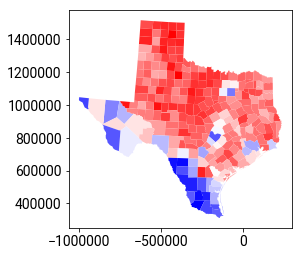

In [15]:
votes.plot("dem_pct_2016", cmap='bwr_r')

In [17]:
#clustering with no attribute information, gamma=0, k=10
aspatial = SPENC(n_clusters=10, gamma=0).fit(X, W=Wm)

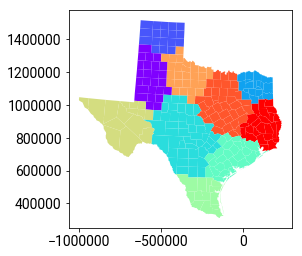

In [18]:
votes.assign(labels=aspatial.labels_).plot("labels", cmap='rainbow')

These are just latent in the eigenspectrum of Texan counties. There is no data in this. You can see this yourself just by using arbitrary data in the place of X:

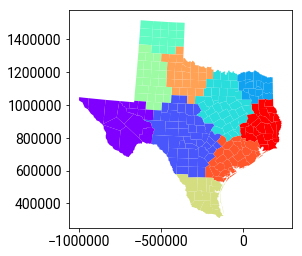

In [23]:
Xrandom = np.random.uniform(-1,1, size=X.shape) # we don't need to set a seed because it literally doesn't matter
votes.assign(labels=SPENC(n_clusters=10, gamma=0).fit(Xrandom, W=Wm).labels_)\
     .plot("labels", cmap='rainbow')

Now, note the distribution of affinities in the final affinity matrix:

(-0.1, 1.1)

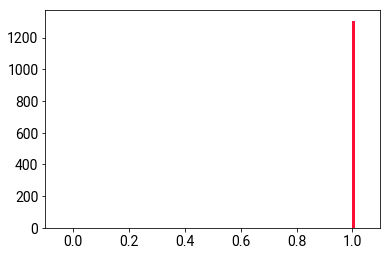

In [51]:
plt.hist(aspatial.affinity_matrix_.toarray()[aspatial.affinity_matrix_.nonzero()].flatten(), bins=100)
plt.xlim(-.1,1.1)

OK, let's spread that out a bit

In [74]:
# with a new gamma=200
g200 = SPENC(n_clusters=10, gamma=200).fit(X, W=Wm)
# with a new gamma=500
g800 = SPENC(n_clusters=10, gamma=800).fit(X, W=Wm)

(-0.1, 1.1)

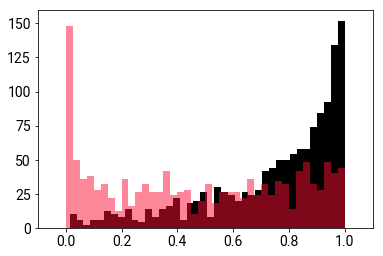

In [76]:
plt.hist(g200.affinity_matrix_.toarray()[g200.affinity_matrix_.nonzero()].flatten(), bins=40, color='k')
plt.hist(g800.affinity_matrix_.toarray()[g800.affinity_matrix_.nonzero()].flatten(), 
         bins=40, alpha=.5, linewidth=3)
plt.xlim(-.1,1.1)

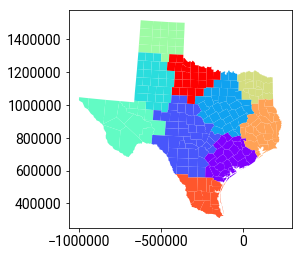

In [77]:
votes.assign(labels=g200.labels_).plot("labels", cmap='rainbow')

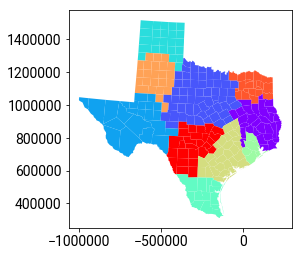

In [78]:
votes.assign(labels=g800.labels_).plot("labels", cmap='rainbow')

And, with a higher-order weight:

In [79]:
Wi_4 = lp.higher_order(Wm, 4).sparse

In [80]:
g200_eta4 = SPENC(n_clusters=10, gamma=200).fit(X, W=Wi_4)

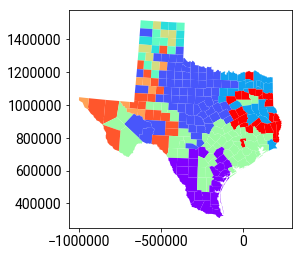

In [81]:
votes.assign(labels=g200_eta4.labels_).plot("labels", cmap='rainbow')

For point data, just use a pysal kernel, distance band, or KNN symmetrized. Make sure it's symmetric. Also, make sure the kernel weights (if you use them) have their diagonals filled with zero before they're used, otherwise the Laplacian is incorrect. 